In [3]:
# Import libraries to use logistic regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score, r2_score
from sklearn.calibration import cross_val_predict
import itertools
import statsmodels.api as sm


In [4]:
credit_data = pd.read_csv('csv_files/credit.csv')

In [5]:
credit_data = credit_data.drop(columns=['Unnamed: 0'])

In [10]:
# Run logistic regression using WC/TA, RE/TA, EBIT/TA, ME/TL, S/TA with 50% benchmark
X = credit_data[['WC/TA', 'RE/TA', 'EBIT/TA', 'ME/TL', 'S/TA']]
y = credit_data['Default']

weight_for_0 = 0.5  # Weight for the non-default class
weight_for_1 = 0.5  # Weight for the default class

class_weights = {0: weight_for_0, 1: weight_for_1}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

logistic = linear_model.LogisticRegression(class_weight=class_weights)
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_train)


In [11]:
print('R2 Score:', r2_score(y_train, y_pred))
print('Accuracy Score:', accuracy_score(y_train, y_pred))
print('Confusion Matrix:', confusion_matrix(y_train, y_pred))

R2 Score: -0.06891403426056897
Accuracy Score: 0.9088191330343797
Confusion Matrix: [[600   6]
 [ 55   8]]


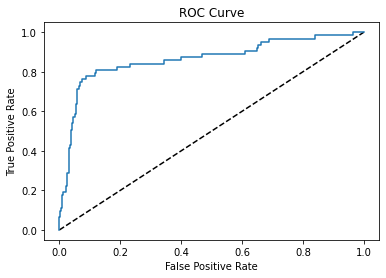

ROC AUC Score: 0.8631934622033632


In [12]:
# Create ROC Curve
y_pred_proba = logistic.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print ROC Curve Statistics
print('ROC AUC Score:', roc_auc_score(y_train, y_pred_proba))

Test Truth Table
Accuracy Score: 0.9066666666666666
Confusion Matrix: [[67  1]
 [ 6  1]]


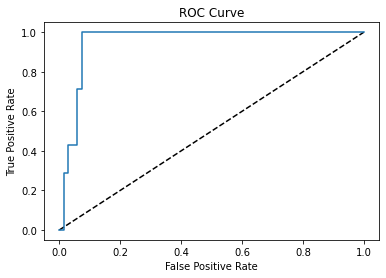

ROC AUC Score: 0.9537815126050421


In [13]:
y_pred_test = logistic.predict(X_test)

# Calculate truth table for test
print('Test Truth Table')
print('Accuracy Score:', accuracy_score(y_test, y_pred_test))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred_test))

# Create ROC Curve for test
y_pred_proba = logistic.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print ROC Curve Statistics
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))


In [14]:
loo = LeaveOneOut()

# Initialize lists to store predictions and actual labels
predictions = []
true_labels = []

# Iterate through each training and testing set from LOOCV
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the logistic regression model
    logistic = linear_model.LogisticRegression(class_weight=class_weights)
    logistic.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = logistic.predict(X_test)

    # Store the predictions and true labels
    predictions.append(y_pred)
    true_labels.append(y_test.values[0])

# Convert lists to arrays for easier manipulation
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Print results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC AUC score
y_pred_proba = logistic.predict_proba(X)[:,1]
roc_auc = roc_auc_score(y, y_pred_proba)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.907258064516129
Confusion Matrix:
[[667   7]
 [ 62   8]]
ROC AUC Score: 0.873908435777872


In [15]:
# Define the number of folds
k = 10

# Initialize lists to store predictions and actual labels
predictions = []
true_labels = []

# Initialize KFold
kf = KFold(n_splits=k)

# Iterate through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the logistic regression model
    logistic = linear_model.LogisticRegression(class_weight=class_weights)
    logistic.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = logistic.predict(X_test)

    # Store the predictions and true labels
    predictions.extend(y_pred)
    true_labels.extend(y_test)

# Convert lists to arrays for easier manipulation
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Print results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC AUC score
y_pred_proba = logistic.predict_proba(X)[:,1]
roc_auc = roc_auc_score(y, y_pred_proba)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.8978494623655914
Confusion Matrix:
[[667   7]
 [ 69   1]]
ROC AUC Score: 0.8762611275964391


In [16]:
# Function to perform Best Subset Regression
def best_subset_regression(X, y, criterion='aic'):
    results = []
    for k in range(1, len(X.columns) + 1):
        subsets = itertools.combinations(X.columns, k)
        for subset in subsets:
            model = sm.Logit(y, sm.add_constant(X[list(subset)])).fit(disp=0)
            if criterion == 'aic':
                results.append((model, model.aic, subset))
            elif criterion == 'bic':
                results.append((model, model.bic, subset))
    
    # Select the model with the minimum AIC/BIC
    best_model = min(results, key=lambda x: x[1])
    return best_model

# Perform Best Subset Regression using BIC
best_model_bic = best_subset_regression(X, y, criterion='bic')
print("\nBest Subset Regression using BIC:")
print("BIC:", best_model_bic[1])
print("Variables:", best_model_bic[2])
print(best_model_bic[0].summary())



Best Subset Regression using BIC:
BIC: 365.72154205076663
Variables: ('RE/TA', 'ME/TL')
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                  744
Model:                          Logit   Df Residuals:                      741
Method:                           MLE   Df Model:                            2
Date:                Sat, 18 May 2024   Pseudo R-squ.:                  0.2547
Time:                        14:31:15   Log-Likelihood:                -172.94
converged:                       True   LL-Null:                       -232.05
Covariance Type:            nonrobust   LLR p-value:                 2.145e-26
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8320      0.235     -3.543      0.000      -1.292      -0.372
RE/TA         -1.1031      0.288     -3.82

# Part B

## Part B - a

In [6]:
X = credit_data[['WC/TA', 'RE/TA', 'EBIT/TA', 'ME/TL', 'S/TA']]  # predictors
y = credit_data['Default']   # response

ridge = Ridge()
parameters = {'alpha': np.logspace(-4, 4, 100)}
ridge_cv = GridSearchCV(ridge, parameters, cv=10, scoring='neg_mean_squared_error')
ridge_cv.fit(X, y)

ridge_best_model = ridge_cv.best_estimator_
ridge_coefficients = ridge_best_model.coef_
print("Ridge coefficients:", ridge_coefficients)

Ridge coefficients: [ 0.01264678 -0.19656106 -1.03983187 -0.00933357  0.16121051]


In [7]:
lasso = Lasso()
parameters = {'alpha': np.logspace(-4, 4, 100)}
lasso_cv = GridSearchCV(lasso, parameters, cv=10, scoring='neg_mean_squared_error')
lasso_cv.fit(X, y)

lasso_best_model = lasso_cv.best_estimator_
lasso_coefficients = lasso_best_model.coef_
print("LASSO coefficients:", lasso_coefficients)


LASSO coefficients: [ 0.00666395 -0.19746534 -0.95038793 -0.00953055  0.15669492]


In [8]:
elastic_net = ElasticNet()
parameters = {'alpha': np.logspace(-4, 4, 100), 'l1_ratio': np.linspace(0, 1, 10)}
elastic_net_cv = GridSearchCV(elastic_net, parameters, cv=10, scoring='neg_mean_squared_error')
elastic_net_cv.fit(X, y)

elastic_net_best_model = elastic_net_cv.best_estimator_
elastic_net_coefficients = elastic_net_best_model.coef_
print("Elastic Net coefficients:", elastic_net_coefficients)

/Users/fethikahvecioglu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.503650119022154, tolerance: 0.0060289985052316905
  model = cd_fast.enet_coordinate_descent(
/Users/fethikahvecioglu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.853911540630786, tolerance: 0.005868460388639762
  model = cd_fast.enet_coordinate_descent(
/Users/fethikahvecioglu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.650172973262805, tolerance: 0.006188340807174888
  model = cd_fast.enet_coordinate_descent(
/Users/fethikahvecioglu/opt

Elastic Net coefficients: [ 0.00949651 -0.19815175 -0.95745231 -0.00955268  0.15875159]


/Users/fethikahvecioglu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.879868972499615, tolerance: 0.006341397849462365
  model = cd_fast.enet_coordinate_descent(


### Commentary on Coefficients

Let's analyze and comment on the coefficients obtained from Ridge, LASSO, and Elastic Net regression models. Here's a detailed commentary:

#### Ridge Regression Coefficients

Ridge coefficients: [ 0.01264678 -0.19656106 -1.03983187 -0.00933357  0.16121051]

- **Overview**: Ridge regression shrinks the coefficients but retains all features in the model. It uses \( \ell_2 \)-norm regularization, which penalizes the sum of the squared coefficients.
- **Interpretation**:
  - The first coefficient (0.0126) indicates a small positive effect of the corresponding predictor.
  - The second coefficient (-0.1966) indicates a moderate negative effect.
  - The third coefficient (-1.0398) indicates a strong negative effect, suggesting this predictor is significantly inversely related to the response variable.
  - The fourth coefficient (-0.0093) indicates a very small negative effect.
  - The fifth coefficient (0.1612) indicates a moderate positive effect.
- **Key Point**: Ridge does not set any coefficients to zero, hence all features are retained in the model.

#### LASSO Regression Coefficients

LASSO coefficients: [ 0.00666395 -0.19746534 -0.95038793 -0.00953055  0.15669492]

- **Overview**: LASSO regression can shrink some coefficients to exactly zero using \( \ell_1 \)-norm regularization, which is useful for feature selection.
- **Interpretation**:
  - The first coefficient (0.0067) is close to zero but positive, indicating a minimal positive effect.
  - The second coefficient (-0.1975) is slightly stronger than in Ridge, indicating a moderate negative effect.
  - The third coefficient (-0.9504) is still negative but slightly less strong than in Ridge.
  - The fourth coefficient (-0.0095) indicates a very small negative effect, similar to Ridge.
  - The fifth coefficient (0.1567) indicates a moderate positive effect.
- **Key Point**: In this case, none of the coefficients are exactly zero, indicating that LASSO did not perform feature selection here, but the coefficients are generally smaller in magnitude compared to Ridge.

#### Elastic Net Regression Coefficients

Elastic Net coefficients: [ 0.00949651 -0.19815175 -0.95745231 -0.00955268  0.15875159]

- **Overview**: Elastic Net combines both \( \ell_1 \) and \( \ell_2 \)-norm regularization, balancing Ridge and LASSO properties.
- **Interpretation**:
  - The first coefficient (0.0095) is positive and small, indicating a minimal positive effect.
  - The second coefficient (-0.1982) is a moderate negative effect, similar to LASSO.
  - The third coefficient (-0.9575) is negative, closer to LASSO but slightly more than Ridge.
  - The fourth coefficient (-0.0096) indicates a very small negative effect, very close to Ridge and LASSO.
  - The fifth coefficient (0.1588) indicates a moderate positive effect, similar to LASSO and Ridge.
- **Key Point**: Elastic Net coefficients are similar to those of LASSO but slightly more balanced, showcasing a compromise between the Ridge and LASSO results.

### Summary of Comparison
- **Magnitude**: Ridge generally produces larger coefficients compared to LASSO and Elastic Net due to its \( \ell_2 \) penalty.
- **Sparsity**: While LASSO is known for sparsity, in this case, it didn't set any coefficients to zero. Elastic Net did not set any coefficients to zero either but provides a balance between Ridge and LASSO.
- **Feature Retention**: All models retained all features in this scenario, but if there were more noise or redundant features, LASSO or Elastic Net might set some coefficients to zero.

These coefficients indicate how each model treats the predictors in relation to the response variable, showing slight variations based on the type of regularization applied.


## Part B - b

In [24]:
k = 10
# Perform k-fold cross-validation and obtain predicted values for each fold
ridge_cv_preds = cross_val_predict(ridge_best_model, X_train, y_train, cv=k)
lasso_cv_preds = cross_val_predict(lasso_best_model, X_train, y_train, cv=k)
elastic_net_cv_preds = cross_val_predict(elastic_net_best_model, X_train, y_train, cv=k)

# Initialize an empty list to store confusion matrices for each fold
ridge_accuracies = []
ridge_precisions = []
ridge_recalls = []
ridge_f1_scores = []
ridge_specificities = []

lasso_accuracies = []
lasso_precisions = []
lasso_recalls = []
lasso_f1_scores = []
lasso_specificities = []

elastic_net_accuracies = []
elastic_net_precisions = []
elastic_net_recalls = []
elastic_net_f1_scores = []
elastic_net_specificities = []


# Calculate confusion matrix for each fold
for fold in range(k):
    # Extract predictions and true labels for the current fold
    ridge_fold_preds = ridge_cv_preds[fold*len(X_train)//k : (fold+1)*len(X_train)//k]
    lasso_fold_preds = lasso_cv_preds[fold*len(X_train)//k : (fold+1)*len(X_train)//k]
    elastic_fold_preds = elastic_net_cv_preds[fold*len(X_train)//k : (fold+1)*len(X_train)//k]

    fold_true_labels = y_train[fold*len(X_train)//k : (fold+1)*len(X_train)//k]
    
    # Calculate confusion matrix for the current fold
    ridge_conf_matrix = confusion_matrix(fold_true_labels, (ridge_fold_preds > 0.5).astype(int))
    lasso_conf_matrix = confusion_matrix(fold_true_labels, (lasso_fold_preds > 0.5).astype(int))
    elastic_net_conf_matrix = confusion_matrix(fold_true_labels, (elastic_fold_preds > 0.5).astype(int))
    
    # Calculate and append statistics for the current fold
    ridge_accuracies.append(accuracy_score(fold_true_labels, (ridge_fold_preds > 0.5).astype(int)))
    ridge_precisions.append(ridge_conf_matrix[1, 1] / (ridge_conf_matrix[1, 1] + ridge_conf_matrix[0, 1]))
    ridge_recalls.append(ridge_conf_matrix[1, 1] / (ridge_conf_matrix[1, 1] + ridge_conf_matrix[1, 0]))
    ridge_f1_scores.append(2 * ridge_precisions[-1] * ridge_recalls[-1] / (ridge_precisions[-1] + ridge_recalls[-1]))
    ridge_specificities.append(ridge_conf_matrix[0, 0] / (ridge_conf_matrix[0, 0] + ridge_conf_matrix[0, 1]))

    lasso_accuracies.append(accuracy_score(fold_true_labels, (lasso_fold_preds > 0.5).astype(int)))
    lasso_precisions.append(lasso_conf_matrix[1, 1] / (lasso_conf_matrix[1, 1] + lasso_conf_matrix[0, 1]))
    lasso_recalls.append(lasso_conf_matrix[1, 1] / (lasso_conf_matrix[1, 1] + lasso_conf_matrix[1, 0]))
    lasso_f1_scores.append(2 * lasso_precisions[-1] * lasso_recalls[-1] / (lasso_precisions[-1] + lasso_recalls[-1]))
    lasso_specificities.append(lasso_conf_matrix[0, 0] / (lasso_conf_matrix[0, 0] + lasso_conf_matrix[0, 1]))

    elastic_net_accuracies.append(accuracy_score(fold_true_labels, (elastic_fold_preds > 0.5).astype(int)))
    elastic_net_precisions.append(elastic_net_conf_matrix[1, 1] / (elastic_net_conf_matrix[1, 1] + elastic_net_conf_matrix[0, 1]))
    elastic_net_recalls.append(elastic_net_conf_matrix[1, 1] / (elastic_net_conf_matrix[1, 1] + elastic_net_conf_matrix[1, 0]))
    elastic_net_f1_scores.append(2 * elastic_net_precisions[-1] * elastic_net_recalls[-1] / (elastic_net_precisions[-1] + elastic_net_recalls[-1]))
    elastic_net_specificities.append(elastic_net_conf_matrix[0, 0] / (elastic_net_conf_matrix[0, 0] + elastic_net_conf_matrix[0, 1]))

/Users/fethikahvecioglu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.248752454692827, tolerance: 0.002579104477611939
  model = cd_fast.enet_coordinate_descent(
/Users/fethikahvecioglu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.027250327667522, tolerance: 0.0023044776119402976
  model = cd_fast.enet_coordinate_descent(
/Users/fethikahvecioglu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.67595445166298, tolerance: 0.002669983416252073
  model = cd_fast.enet_coordinate_descent(
/Users/fethikahvecioglu/opt/

In [18]:
# Print the average ridge statistics across all folds
print("Ridge Regression:")
print("Average Accuracy:", np.mean(ridge_accuracies))
print("Average Precision:", np.mean(ridge_precisions))
print("Average Recall:", np.mean(ridge_recalls))
print("Average F1 Score:", np.mean(ridge_f1_scores))
print("Average Specificity:", np.mean(ridge_specificities))

Ridge Regression:
Average Accuracy: 0.955223880597015
Average Precision: nan
Average Recall: 0.0
Average F1 Score: nan
Average Specificity: 0.9984615384615385


In [19]:
# Print the average lasso statistics across all folds
print("LASSO Regression:")
print("Average Accuracy:", np.mean(lasso_accuracies))
print("Average Precision:", np.mean(lasso_precisions))
print("Average Recall:", np.mean(lasso_recalls))
print("Average F1 Score:", np.mean(lasso_f1_scores))
print("Average Specificity:", np.mean(lasso_specificities))

LASSO Regression:
Average Accuracy: 0.955223880597015
Average Precision: nan
Average Recall: 0.0
Average F1 Score: nan
Average Specificity: 0.9984615384615385


In [20]:
# Print the average elastic net statistics across all folds
print("Elastic Net Regression:")
print("Average Accuracy:", np.mean(elastic_net_accuracies))
print("Average Precision:", np.mean(elastic_net_precisions))
print("Average Recall:", np.mean(elastic_net_recalls))
print("Average F1 Score:", np.mean(elastic_net_f1_scores))
print("Average Specificity:", np.mean(elastic_net_specificities))

Elastic Net Regression:
Average Accuracy: 0.955223880597015
Average Precision: nan
Average Recall: 0.0
Average F1 Score: nan
Average Specificity: 0.9984615384615385


## Part B - c

# Part C

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Load the data
yield_data = pd.read_csv('csv_files/turkish_yields.csv')

# Changing only the first column name to date
yield_data.columns.values[0] = "Date"

# Convert the date column to datetime format
yield_data["Date"] = pd.to_datetime(yield_data["Date"], format='%d.%m.%Y')

In [16]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler

# Drop non-numeric columns if any
data_numeric = yield_data.drop('Date', axis=1)  # Assuming 'Date' is the non-numeric column

# Handle missing values if any
data_numeric.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Apply PCA
pca = PCA()
pca.fit(data_scaled)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each principal component
print("Explained Variance Ratio for each Principal Component:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.4f}")

# You can also access the principal components themselves
principal_components = pca.components_

# Transform the original data to the new PCA space
data_pca = pca.transform(data_scaled)

# Convert the transformed data to a DataFrame for further analysis if needed
data_pca_df = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])

# Concatenate the transformed data with the original data (if needed)
# final_data = pd.concat([data['Date'], data_pca_df], axis=1)

Explained Variance Ratio for each Principal Component:
PC1: 0.9474
PC2: 0.0433
PC3: 0.0082
PC4: 0.0010
PC5: 0.0000
PC6: 0.0000
PC7: 0.0000
PC8: 0.0000
PC9: 0.0000


In [18]:
# Calculate differences
for i in range(1, len(yield_data.columns)):
    yield_data[yield_data.columns[i] + '_diff'] = yield_data[yield_data.columns[i]] - yield_data[yield_data.columns[i]].shift(1)

# Drop the first row since it will have NaN values due to differencing
yield_data.dropna(inplace=True)

# Calculate descriptive statistics
statistics = pd.DataFrame(columns=['Variable', 'Mean', 'Median', 'Skewness', 'Kurtosis'])

for column in yield_data.columns[1:]:
    variable = column.split('_')[0]
    mean = np.mean(yield_data[column])
    median = np.median(yield_data[column])
    sk = skew(yield_data[column])
    kurt = kurtosis(yield_data[column])
    statistics = statistics.append({'Variable': variable, 'Mean': mean, 'Median': median, 'Skewness': sk, 'Kurtosis': kurt}, ignore_index=True)

display(statistics)


AttributeError: 'DataFrame' object has no attribute 'append'

### Part C - a: ChatGPT Comments
- The interest rate levels show a consistent right-skewed distribution across different time intervals, with heavier tails indicating the presence of outliers or extreme values.
- Interest rate differences display even heavier tails with significantly higher kurtosis values, suggesting extreme fluctuations or outliers in the data.
- The skewness values for interest rate differences vary, indicating varying degrees of right-skewness in the changes over time.
- Extremely high kurtosis values for interest rate differences suggest that the distribution of changes in interest rates deviates significantly from a normal distribution, indicating high volatility or non-stationarity in the data.

### Part C - b:

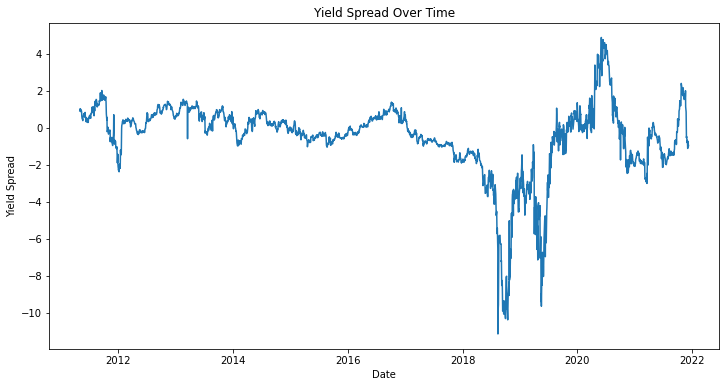

In [26]:
# Display a time series plot of the yield spread
plt.figure(figsize=(12, 6))
plt.plot(yield_data["Date"], yield_data['yield_spread'])
plt.xlabel('Date')
plt.ylabel('Yield Spread')
plt.title('Yield Spread Over Time')
plt.show()

In [22]:
# Count the number of months where yields are positive
positive_10Y = (yield_data['X3600'] > 0).sum()
positive_2Y = (yield_data['X720'] > 0).sum()

print("Number of months with positive 10-year yield:", positive_10Y)
print("Number of months with positive 2-year yield:", positive_2Y)

Number of months with positive 10-year yield: 2658
Number of months with positive 2-year yield: 2658


In [23]:
# Calculate the yield spread (e.g., 10-year minus 2-year)
yield_data['yield_spread'] = yield_data['X3600'] - yield_data['X720']

# Find periods of yield curve flattening
flattening_periods = []
previous_spread = None

for index, row in yield_data.iterrows():
    current_spread = row['yield_spread']
    
    if previous_spread is not None:
        if current_spread <= previous_spread:
            flattening_periods.append(row['Date'])
    
    previous_spread = current_spread

# Print identified flattening periods
print("Periods of Yield Curve Flattening:")
for period in flattening_periods:
    print(period.strftime('%d.%m.%Y'))

display(yield_data['yield_spread'])
print("Mean Yield Spread:", yield_data['yield_spread'].mean())
print((yield_data['yield_spread'] > 0).sum())

Periods of Yield Curve Flattening:
10.05.2011
13.05.2011
17.05.2011
18.05.2011
20.05.2011
23.05.2011
24.05.2011
01.06.2011
02.06.2011
03.06.2011
06.06.2011
09.06.2011
10.06.2011
13.06.2011
15.06.2011
20.06.2011
21.06.2011
22.06.2011
23.06.2011
27.06.2011
28.06.2011
04.07.2011
08.07.2011
12.07.2011
13.07.2011
18.07.2011
25.07.2011
27.07.2011
29.07.2011
01.08.2011
02.08.2011
03.08.2011
04.08.2011
08.08.2011
12.08.2011
16.08.2011
18.08.2011
19.08.2011
22.08.2011
23.08.2011
24.08.2011
29.08.2011
05.09.2011
08.09.2011
14.09.2011
15.09.2011
19.09.2011
20.09.2011
23.09.2011
27.09.2011
29.09.2011
03.10.2011
05.10.2011
06.10.2011
07.10.2011
10.10.2011
14.10.2011
18.10.2011
19.10.2011
20.10.2011
21.10.2011
24.10.2011
26.10.2011
31.10.2011
02.11.2011
03.11.2011
04.11.2011
11.11.2011
15.11.2011
17.11.2011
21.11.2011
22.11.2011
23.11.2011
25.11.2011
28.11.2011
29.11.2011
30.11.2011
08.12.2011
09.12.2011
12.12.2011
13.12.2011
15.12.2011
19.12.2011
20.12.2011
21.12.2011
22.12.2011
26.12.2011
28.12.20

1       0.913700
2       0.999000
3       1.023800
4       0.867700
5       0.908100
          ...   
2654   -0.987399
2655   -1.125377
2656   -0.748496
2657   -1.017789
2658   -0.962943
Name: yield_spread, Length: 2658, dtype: float64

Mean Yield Spread: -0.513875198645598
1193


### Part C - d

In [28]:
# Find periods of yield curve steepening
steepening_periods = []
previous_spread = None

for index, row in yield_data.iterrows():
    current_spread = row['yield_spread']
    
    if previous_spread is not None:
        if current_spread >= previous_spread:
            steepening_periods.append(row['Date'])
    
    previous_spread = current_spread

# Print identified steepening periods
print("Periods of Yield Curve Steepening:")
for period in steepening_periods:
    print(period.strftime('%d.%m.%Y'))

Periods of Yield Curve Steepening:
06.05.2011
09.05.2011
11.05.2011
12.05.2011
16.05.2011
25.05.2011
26.05.2011
27.05.2011
30.05.2011
31.05.2011
07.06.2011
08.06.2011
14.06.2011
16.06.2011
17.06.2011
24.06.2011
29.06.2011
30.06.2011
01.07.2011
05.07.2011
06.07.2011
07.07.2011
11.07.2011
14.07.2011
15.07.2011
19.07.2011
20.07.2011
21.07.2011
22.07.2011
26.07.2011
28.07.2011
05.08.2011
09.08.2011
10.08.2011
11.08.2011
15.08.2011
17.08.2011
25.08.2011
26.08.2011
02.09.2011
06.09.2011
07.09.2011
09.09.2011
12.09.2011
13.09.2011
16.09.2011
21.09.2011
22.09.2011
26.09.2011
28.09.2011
30.09.2011
04.10.2011
11.10.2011
12.10.2011
13.10.2011
17.10.2011
25.10.2011
27.10.2011
28.10.2011
01.11.2011
10.11.2011
14.11.2011
16.11.2011
18.11.2011
24.11.2011
01.12.2011
02.12.2011
05.12.2011
06.12.2011
07.12.2011
14.12.2011
16.12.2011
23.12.2011
27.12.2011
02.01.2012
09.01.2012
11.01.2012
12.01.2012
13.01.2012
18.01.2012
19.01.2012
24.01.2012
25.01.2012
26.01.2012
27.01.2012
30.01.2012
31.01.2012
01.02.20

In [30]:
# Filter data for each year
data_2013 = yield_data[yield_data['Date'].dt.year == 2013].copy()
data_2018 = yield_data[yield_data['Date'].dt.year == 2018].copy()
data_2019 = yield_data[yield_data['Date'].dt.year == 2019].copy()

# Drop non-numeric columns if any
data_2013_numeric = data_2013.drop('Date', axis=1)
data_2018_numeric = data_2018.drop('Date', axis=1)
data_2019_numeric = data_2019.drop('Date', axis=1)

# Handle missing values if any
data_2013_numeric.dropna(inplace=True)
data_2018_numeric.dropna(inplace=True)
data_2019_numeric.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
data_2013_scaled = scaler.fit_transform(data_2013_numeric)
data_2018_scaled = scaler.fit_transform(data_2018_numeric)
data_2019_scaled = scaler.fit_transform(data_2019_numeric)

# Apply PCA for each year
pca_2013 = PCA()
pca_2013.fit(data_2013_scaled)
pca_2018 = PCA()
pca_2018.fit(data_2018_scaled)
pca_2019 = PCA()
pca_2019.fit(data_2019_scaled)

# Get the explained variance ratio for each year
explained_variance_ratio_2013 = pca_2013.explained_variance_ratio_
explained_variance_ratio_2018 = pca_2018.explained_variance_ratio_
explained_variance_ratio_2019 = pca_2019.explained_variance_ratio_

# Print the explained variance ratio for each principal component for each year
print("Explained Variance Ratio for each Principal Component:")
print("Year 2013:")
for i, ratio in enumerate(explained_variance_ratio_2013):
    print(f"PC{i+1}: {ratio:.4f}")

print("\nYear 2018:")
for i, ratio in enumerate(explained_variance_ratio_2018):
    print(f"PC{i+1}: {ratio:.4f}")

print("\nYear 2019:")
for i, ratio in enumerate(explained_variance_ratio_2019):
    print(f"PC{i+1}: {ratio:.4f}")

Explained Variance Ratio for each Principal Component:
Year 2013:
PC1: 0.4964
PC2: 0.3055
PC3: 0.1090
PC4: 0.0435
PC5: 0.0227
PC6: 0.0141
PC7: 0.0070
PC8: 0.0014
PC9: 0.0004
PC10: 0.0000
PC11: 0.0000
PC12: 0.0000
PC13: 0.0000
PC14: 0.0000
PC15: 0.0000
PC16: 0.0000
PC17: 0.0000
PC18: 0.0000
PC19: 0.0000

Year 2018:
PC1: 0.4678
PC2: 0.2051
PC3: 0.1717
PC4: 0.0801
PC5: 0.0347
PC6: 0.0183
PC7: 0.0150
PC8: 0.0045
PC9: 0.0025
PC10: 0.0002
PC11: 0.0000
PC12: 0.0000
PC13: 0.0000
PC14: 0.0000
PC15: 0.0000
PC16: 0.0000
PC17: 0.0000
PC18: 0.0000
PC19: 0.0000

Year 2019:
PC1: 0.4821
PC2: 0.1956
PC3: 0.1866
PC4: 0.0489
PC5: 0.0443
PC6: 0.0231
PC7: 0.0173
PC8: 0.0013
PC9: 0.0005
PC10: 0.0003
PC11: 0.0000
PC12: 0.0000
PC13: 0.0000
PC14: 0.0000
PC15: 0.0000
PC16: 0.0000
PC17: 0.0000
PC18: 0.0000
PC19: 0.0000


# Part E